# Generating Topics from Reason for Recall

There are many possible reasons for recall according to our FDA datasets. While foodborne pathogens such as E. Coli and Listeria are among the common reasons, there are also labelling issues, such as undeclared ingedients, and other reasons for recall, with varying degrees of danger to consumers. In the FDA recall data, reason for recall is recorded in detail. However, it is an unstructured text field. Therefore, it is difficult to aggregate the recall data and provide summary statistics or connect this feature to the review data. Moreover, the reviews corresponding to different recalls vary in vocabulary according to reason for recall sometimes. For example, if someone is allergic to peanuts, and the product does not declare that it contains peanuts, the consumer explains this in their review with different vocabulary from someone who writes that they got sick for other reasons. Therefore, it is worth exploring this aspect of the recall data, as it could be included as a feature in our predictive classification model.

For this exercise, we will implement the Non-negative Matrix Factorization (NMF) algorithm from the [scikit-learn](http://scikit-learn.org/stable/) package, using Nonnegative Double Singular Value Decomposition (NNDSVD) as our parameter which determines number oof components. [Click here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) for more information on the NMF method provided by scikit-learn.

In [1]:
import psycopg2

#We also want to import pandas and numpy to work with the data we have fetched
import pandas as pd
import numpy as np

#Connect to database
conn = psycopg2.connect(<USE YOUR DB CREDENTIALS HERE>)

print("Opened database successfully")

Opened database successfully


In [2]:
cur = conn.cursor()

First, we will extract the reason for recall text from the Event table in our database, along with the event_id for reference.

In [3]:
cur.execute('SELECT REASON, EVENT_ID FROM EVENT;')
event_data = pd.DataFrame(cur.fetchall())

In [4]:
pd.set_option('display.max_colwidth',800)

In [5]:
event_data.columns = ['reason', 'event_id']
event_data

,reason,event_id
0,GL Food Wholesale is recalling Tausi Brand Salted Black Beans because it may have the potential for pathogen growth and toxin formation due to Clostridium botulinum or other spoilage organisms.,30329
1,Golden Dharma International is recalling Tausi Brand Salted Black Beans because it may have the potential for pathogen growth and toxin formation due to Clostridium botulinum or other spoilage organisms.,30330
2,Mandalay Trading is recalling Tausi Brand Salted Black Beans because it may have the potential for pathogen growth and toxin formation due to Clostridium botulinum or other spoilage organisms.,30331
3,Walong is recalling Tausi Brand Salted Black Beans because it may have the potential for pathogen growth and toxin formation due to Clostridium botulinum or other spoilage organisms.,30332
4,Altiza is recalling Malichita brand cucumbers because they may be contaminated with Salmonella.,30333
5,Man Fon is recalling Yangchun Noodles because they contain undeclared wheat allergen.,30334
6,"Pacific American Fish Company (PAFCO) is recalling recalling Korean Oysters because the product has been prepared, packed, or held under insanitary conditions whereby it may have become contaminated with filth, or whereby it may have been rendered injurious to health.",30335
7,"Possible undeclared allergens. Milk, eggs, yellow #5, yellow #6 and red 40.",30336
8,The firm had pecans and not walnuts listed in their ingredient statement.,30337
9,The product is being recalled because it was manufactured using peanut products recalled by Peanut Corporation of America because it has the potential to be contaminated with Salmonella.,30338


Now we want to preprocess the text in preparation for the Non-negative Matrix Factorization. This process is similar to the process taken in the [initial Sentiment Analysis](Text Mining Amazon Reviews.ipynb).

In [6]:
#remove special characters, numbers, etc.
import re #regular expressions module in Python

event_text = [re.sub('[^a-zA-Z\s]', ' ',event_data.reason[i]) for i in range(event_data.shape[0])]

In [7]:
'''
Tokenize the text. NOTE: In NLTK you have to run nltk.download() to run the download client. From
here you will be able to select 'punkt' which gives you access to the NLTK word tokenizer method 
as seen below.
'''
from nltk import word_tokenize

tokens_reason = [word_tokenize(reason) for reason in event_text]
reason_lens = [len(token_reason) for token_reason in tokens_reason]
print('Max: %d\t Min: %d' %(max(reason_lens), min(reason_lens)))
event_data['reason_lengths'] = reason_lens
event_data[event_data.reason_lengths > 50]

Max: 77	 Min: 1


,reason,event_id,reason_lengths
12,"The recalling firm manufactured and distributed peanut products which contained peanuts and/or peanut butter which they received from there bulk peanut supplier, Peanut Corporation of America (PCA). Peanuts and peanut products produced by PCA have been implicated in a recent outbreak of salmonellosis and these product may be contaminated with Salmonella Typhimurium.",30341,53
29,"On the evening of Friday, July 6, 2012, Ingredion, Inc. (f/k/a Corn Products U.S., Inc.) the supplier of Galactooligosaccharide (GOS), an ingredient included, in iFlora¿ Kids Multi Probiotic, notified our contract manufacturer that two lots of their GOS material supplied for inclusion in our products were being recalled for a suspected salmonella contamination. Although our contract manufacturer",30354,58
1329,"The products contain synthetic equivalents of spermine and/or spermidine, which are constituents or extracts of an herb or other botanical, and the that a synthetic copy of a constituent or extract of an herb or other botanical is not a dietary ingredient, and such ingredients must be approved for use in supplements. The use has not been approved.",30388,59
3226,"South Florida Produce of Boynton Beach in Florida shipped fresh jalapeno peppers to Castellini Company in Wilder Kentucky. Castellini shipped the peppers to a store in Ohio, where the Ohio Department of Agriculture collected a sample of these peppers which subsequently were found contaminated with Salmonella. This same lot of fresh peppers was shipped to Club Chef which manufactured the Salsa wh",30373,62
3237,"The recall was initiated after it was discovered during a routine inspection that the products i.e. various kinds of flours, legumes and spices were cross packaged on shared equipment with peanuts and wheat flour. The products i.e. various kinds of flours, legumes and spices were distributed in packaging that did not reveal the presence of peanuts or wheat, but may contain traces of it.",30394,66
3250,"Chicken of the Sea is recalling Oysters supplied by Chicken of the Sea under the Chicken of the Sea, Pacific Pearl, and Ace of Diamonds brands because the products have been prepared, packed, or held under insanitary conditions whereby it may have become contaminated with filth, or whereby it may have been rendered injurious to health.",30409,56
3264,Ultradent is recalling 36 lots of cinnamon flavored Xylishield gum sold in cartons containing 60 individual pieces as well as within the Xylishield dental care kit due to the omission of the major allergen Soy as a sub-ingredient in the ingredients statement. They are also recalling a single lot of spearmint flavored gum as it was accidentally manufactured with cinnamon flavored product.,30423,61
3273,"Queso flavored Pringles, 40 gram and 139 gram sizes, sent to distribution centers in Mexico and Grenada are being recalled because the flavoring ingredient ( under a separate recall) may be contaminated with metal fragments. Pringles processing includes metal fragment seasoning screening and finished product metal detection to 1. 4 mm size. Pringles product containing the recalled seasoning",30432,53
3279,"Inspectional evidence and sample analyses as well as reports of food borne illness outbreaks due to norovirus have led FDA to believe that Korean molluscan shellfish and products containing KMS as ingredients are adulterated under Section 40(a)(4) in that they were prepared and held under insanitary conditions, whereby they may have become contaminated with filth or whereby they may have been rend",30438,62
3286,"Inspectional evidence and sample analyses as well as reports of food borne illness outbreaks due to norovirus have led FDA to believe that Korean molluscan shellfish and products containing KMS as ingredients are adulterated under Section 40(a)(4) in that they were prepared and held under insanitary conditions, whereby they may have become contaminated with filth or whereby they may have be

## Removing Unwanted Proper Nouns

Before stemming the text and removing sparse terms, we want to first perform Named Entity Recognition to remove proper nouns. This is because, for the purpose of generating topics concerning place names and brands, we want to remove such things to facilitate the clustering of the documents. 

In [8]:
import nltk

tagged_tokens = []

for token_set in tokens_reason:
    tagged_tokens.append(nltk.pos_tag(token_set))
    
print(tagged_tokens[:20])

[[('GL', 'NNP'), ('Food', 'NNP'), ('Wholesale', 'NNP'), ('is', 'VBZ'), ('recalling', 'VBG'), ('Tausi', 'NNP'), ('Brand', 'NNP'), ('Salted', 'NNP'), ('Black', 'NNP'), ('Beans', 'NNP'), ('because', 'IN'), ('it', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('the', 'DT'), ('potential', 'NN'), ('for', 'IN'), ('pathogen', 'NN'), ('growth', 'NN'), ('and', 'CC'), ('toxin', 'NN'), ('formation', 'NN'), ('due', 'JJ'), ('to', 'TO'), ('Clostridium', 'NNP'), ('botulinum', 'NN'), ('or', 'CC'), ('other', 'JJ'), ('spoilage', 'NN'), ('organisms', 'NNS')], [('Golden', 'NNP'), ('Dharma', 'NNP'), ('International', 'NNP'), ('is', 'VBZ'), ('recalling', 'VBG'), ('Tausi', 'NNP'), ('Brand', 'NNP'), ('Salted', 'NNP'), ('Black', 'NNP'), ('Beans', 'NNP'), ('because', 'IN'), ('it', 'PRP'), ('may', 'MD'), ('have', 'VB'), ('the', 'DT'), ('potential', 'NN'), ('for', 'IN'), ('pathogen', 'NN'), ('growth', 'NN'), ('and', 'CC'), ('toxin', 'NN'), ('formation', 'NN'), ('due', 'JJ'), ('to', 'TO'), ('Clostridium', 'NNP'), ('botuli

Unfortunately, many foodborne bacteria and diseases will be also identified as proper nouns, and we want to include this vocabulary. To combat this, we will integrate with the [wikipedia](https://pypi.python.org/pypi/wikipedia/) API to perform item lookups on all of the recognized proper nouns and check for their categories. If the categories contain the terms 'disease', 'epidemiology', 'bacteria', 'preservative', 'refrigerant', 'food', 'edible', 'plant', or 'chemical', then they are not removed. This list could be further edited for future analyses.

In [10]:
import wikipedia

nnp_tokens = []
tokens_to_keep = []

#tokens to mark a word as keepable because it's a worthwhile term to keep for clustering
flagged_tokens = ['disease', 'epidemiology', 'bacteria', 'preservative', 'refrigerant', 'food', 'edible', 'plant', 'chemical']

for token_set in tagged_tokens:
    kept_tokens = []
    for token in token_set:
        if token[1] == 'NNP':
            try:
                item = wikipedia.page(token[0])
                nnp_categories = ' '.join(item.categories).lower()
                keep = False
                for token in flagged_tokens:
                    if token in nnp_categories:
                        keep = True
                if keep:
                    kept_tokens.append(token[0])
            except:
                print('Wikipedia page not found for %s' % token[0])
        else:
            kept_tokens.append(token[0])

    tokens_to_keep.append(kept_tokens)

print(tokens_to_keep[:10])
    
tokens_reason = tokens_to_keep

C:\Users\cvint\Anaconda3\lib\site-packages\bs4\__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Wikipedia page not found for GL
Wikipedia page not found for Salted
Wikipedia page not found for Golden
Wikipedia page not found for Salted
Wikipedia page not found for Salted
Wikipedia page not found for Salted
Wikipedia page not found for American
Wikipedia page not found for Frozen
Wikipedia page not found for PCA
Wikipedia page not found for PCA
Wikipedia page not found for Korean
Wikipedia page not found for HACCP
Wikipedia page not found for Inc
Wikipedia page not found for Frozen
Wikipedia page not found for Powder
Wikipedia page not found for Agency
Wikipedia page not found for CFIA
Wikipedia page not found for Southwind
Wikipedia page not found for Terra
Wikipedia page not found for CA
Wikipedia page not found for New
Wikipedia page not found for State
Wikipedia page not found for Department
Wikipedia page not found for Duane
Wikipedia page not found for Oral
Wikipedia page not found for Inc
Wikipedia page not found for Inc
Wikipedia page not found for GOS
Wikipedia page not f

## Final Preprocessing

We can see that there were a few terms that were removed even though we might not want them removed, such as 'Coli' due to the capital 'C'. However, the vast majority of terms that were removed were terms that we do not want. This method can be replaced or modified depending on the text mining needs. Now that we have purged the reasons for recall of some of their content that might throw the clustering model off, we can move on with the rest of the preprocessing and commence the topic modelling task.

In [11]:
'''
Custom methods to split on uppercase letters and then make all lowercase
'''

#split words on uppercase letters
def split_uppercase(tokens):
    tokens_II = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            split = re.sub(r'([A-Z][a-z])', r' \1', word)
            tokens_II[n].append(split)
    return tokens_II

tokens_reason = split_uppercase(tokens_reason)

##Make all text lower case
def make_lowercase(tokens):
    tokens_final = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            lowercase_word = word.lower()
            tokens_final[n].append(lowercase_word)
    return tokens_final

tokens_reason = make_lowercase(tokens_reason)

In [12]:
'''
Stem words and remove stopwords- nltk.download('stopwords')
'''

from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

st = LancasterStemmer()

##Remove stopwords and stem
stopwords = stopwords.words('english')

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
tokens_reason = stem_tokens(tokens_reason)

In [13]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
final_reason_text = []
for reason in tokens_reason:
    for word in reason:
        n = reason.index(word)
        if n == 0:
            string = reason[n]
        else:
            string = string + " " + reason[n]
    final_reason_text.append(string)

## Setting Up for Topic Modelling

Now that we have completed all necessary preprocessing, we must now create the Count Vectorizer Matrix. This is a document-term matrix that stores counts of each term, or token, within each document. This matrix is used to determine relative distance between documents and thus how related they are to each other and how they should be clustered. In many text mining situations, you want to remove sparse terms- that is, terms that don't appear in the corpus (collection of documents) more than n times (n can be 5, 10 or another low number depending on the corpus). This is one aspect of the topic modeling that we need to investigate that relies heavily on the nature of the corpus, in order to optimize the generated topics for our purposes.

In [14]:
##Count Vectorizer Matrix
import scipy
from scipy.sparse import coo_matrix, vstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1)) ##Removed stopwords before stemming so don't apply here
final_reason_text = vectorizer.fit_transform(final_reason_text)

counts = scipy.sparse.coo_matrix.sum(final_reason_text, axis=0)
final_reason_text = np.transpose(vstack([final_reason_text,counts]))
final_reason_text = pd.DataFrame(final_reason_text.todense(), index = vectorizer.get_feature_names())
last_col = final_reason_text.shape[1] - 1
final_reason_text = final_reason_text[final_reason_text[last_col] > 4]
del final_reason_text[last_col]

In [15]:
final_reason_text.shape

(868, 5595)

The next step in the NMF task is Term Frequency-Inverse Document Frequency (TF-IDF) Weighting. This is a measure of a term's importance relative to the document and the corpus, in which a term's document frequency relative to the number of terms in the entire document is offset by the number of ducments in which the term appears.

In [16]:
##TFIDF Weighting
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
weighted_reason_text = transformer.fit_transform(final_reason_text)
tfidf_matrix = weighted_reason_text.transpose()
tfidf_matrix

<5595x868 sparse matrix of type '<class 'numpy.float64'>'
	with 28908 stored elements in Compressed Sparse Column format>

## Estimating Number of Topics

In Topic Modelling, an important task is estimating the best number of topics for what you are trying to do. The NMF method in the sklearn package takes in a set number of topics to create and formulates them that way. We want to determine a good number of topics in a way that goes beyond just a hunch or what we think is a nice-looking number.

For this exercise, we will implement a [Stability Analysis](http://derekgreene.com/stability-analysis/) to estimate the best number of topics to use. A high stability score indicates a good number of topics to use.

In [17]:
'''
Source: http://derekgreene.com/notebooks/stability_kmeans_full.py
'''
import numpy as np
from sklearn import datasets, metrics
from sklearn.cluster import KMeans

def calc_pairwise_stability( clusterings, metric ):
    ''' 
    Calculate mean pairwise stability between a list of disjoint clusterings,
    using the specified metric for measuring the similarity of two disjoint clusterings.
    '''
    sim_values = []
    for i in range(len(clusterings)):
        for j in range(i+1,len(clusterings)):
            sim_values.append( metric( clusterings[i], clusterings[j] ) )
    return np.array( sim_values ).mean()

def kmeans_sample( X, k, sampling_ratio ):
    ''' 
    Apply k-means clustering to a subset of samples from the specified dataset, 
    and return a predicted clustering for the complete dataset based on the original centroids.
    '''
    # create a matrix with subset of samples
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle( indices )
    n_subset = int(n_samples * sampling_ratio) 
    X_subset = X[indices[0:n_subset]] 
    # cluster the subset
    clusterer = KMeans(n_clusters=k, n_init=1, init='random', max_iter = 100)
    clusterer.fit(X_subset)
    # produce an assignment for all samples
    return clusterer.predict(X)

def kmeans_random( X, k ):
    clusterer = KMeans(n_clusters=k, n_init=1, init='random', max_iter = 100)
    clusterer.fit(X)
    return clusterer.labels_

In [18]:
%matplotlib inline

Generating clusterings for k=2 ...
Calculating stability score for k=2 from 100 clusterings ...
Stability at k=2: 0.005
Generating clusterings for k=3 ...
Calculating stability score for k=3 from 100 clusterings ...
Stability at k=3: 0.011
Generating clusterings for k=4 ...
Calculating stability score for k=4 from 100 clusterings ...
Stability at k=4: 0.022
Generating clusterings for k=5 ...
Calculating stability score for k=5 from 100 clusterings ...
Stability at k=5: 0.030
Generating clusterings for k=6 ...
Calculating stability score for k=6 from 100 clusterings ...
Stability at k=6: 0.042
Generating clusterings for k=7 ...
Calculating stability score for k=7 from 100 clusterings ...
Stability at k=7: 0.047
Generating clusterings for k=8 ...
Calculating stability score for k=8 from 100 clusterings ...
Stability at k=8: 0.060
Generating clusterings for k=9 ...
Calculating stability score for k=9 from 100 clusterings ...
Stability at k=9: 0.059
Generating clusterings for k=10 ...
Calc

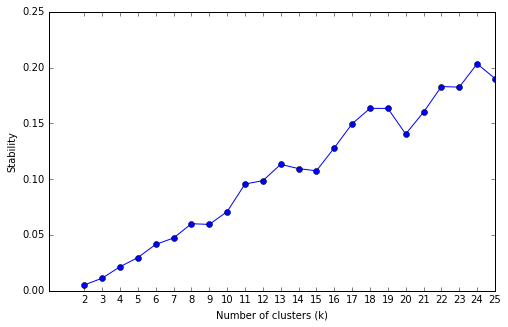

In [19]:
'''
Source: http://derekgreene.com/notebooks/stability_kmeans_full.py
'''

# set random seed
np.random.seed( 1000 )

# load the sample dataset
X = tfidf_matrix

# test a range of values for number of cluster k
kmin = 2
kmax = 25
runs = 100
sampling_ratio = 0.8
stability_values = []
for k in range(kmin, kmax+1):
    # apply clustering to 100 different random samples
    print("Generating clusterings for k=%d ..." % k)
    clusterings_k = [kmeans_sample( X, k, sampling_ratio ) for run in range(runs)]
    # calculate stability for this value of k
    print("Calculating stability score for k=%d from %d clusterings ..." % (k,len(clusterings_k)))
    stability_k = calc_pairwise_stability( clusterings_k, metrics.adjusted_rand_score )
    print("Stability at k=%d: %0.3f" % (k,stability_k))
    stability_values.append( stability_k )

# Plot stability for each value of K 
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8,5))
plt.plot(range(kmin, kmax+1), stability_values, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Stability')
plt.xticks(range(kmin, kmax+1))
plt.show()

We see two primary relative peaks in the above visualization, but for this analysis we will select 24 for our number of topics. This is because the absolute peak lies at k = 24, and we want the minimum necessary number of topics. There are other methods to estimate the best number of topics, and this is dependent on the nature of your data.

## Generating the Topics

Using k = 24 as our number of topics, we will now use our processed, weighted TF-IDF matrix in the Non-Negative Matrix Factorization algorithm and see what topics we come up with.

In [26]:
##Non-negative matrix factorization
n_topics = 24

from sklearn.decomposition import NMF

model = NMF(init="nndsvd", n_components=n_topics, random_state=1)

#This returns the document-topic matrix
W_matrix = model.fit_transform(tfidf_matrix)

#This returns the components, including the terms associated with each topic
H_matrix = model.components_

In [27]:
##Prints tops and keywords

feature_names = final_reason_text.index
for topic_index in range( H_matrix.shape[0] ):
    top_indices = np.argsort( H_matrix[topic_index,:] )[::-1][0:10]  ##show top 10 words associated with each topic
    term_ranking = [feature_names[i] for i in top_indices]
    print ("Topic %d: %s" % ( topic_index, ", ".join( term_ranking ) ))

Topic 0: eld, weak, immun, fat, young, childr, sometim, frail, oth, infect
Topic 1: rend, whereby, held, insanit, becom, condit, injury, heal, fil, prep
Topic 2: scor, end, el, proxim, dist, wherein, cathet, sec, remain, manufacturing
Topic 3: encount, difficulties, prim, control, chang, system, backup, inadequ, obtain, med
Topic 4: run, threatening, sensit, people, allergy, lif, react, sery, sev, consum
Topic 5: alarm, going, ventilators, soon, battery, intern, expect, backup, op, ventil
Topic 6: train, purpos, educ, sim, outsid, intend, us, products, quick, dissolv
Topic 7: bend, outflow, graft, reliev, connect, prop, seal, the, may, loose
Topic 8: adh, string, lay, film, chok, remain, hazard, plast, could, chees
Topic 9: defl, infl, intracr, balloon, comply, concern, proc, compon, potential, manufacturing
Topic 10: foodborn, cid, link, an, cas, appl, confirm, il, outbreak, col
Topic 11: diclofenac, methocarbamol, dexamethason, pharmaceut, tablets, act, ingredy, thick, drug, weight
T

These generated topics can now be saved and utilized in a classification algorithm to attempt to predict recall and/or type of recall.

In [28]:
#save the document-topic matrix as a data frame
doc_top_mat = pd.DataFrame(W_matrix)
doc_top_mat.index = event_data.event_id
pd.DataFrame.to_csv(doc_top_mat, 'document_topic_matrix_reason.csv')

In [29]:
#save topic-term matrix
topic_term_mat = pd.DataFrame(H_matrix)
topic_term_mat.columns =final_reason_text.index
pd.DataFrame.to_csv(topic_term_mat, 'topic_term_matrix_reason.csv')

## Using Topics for Predictive Model

This data was going to be used to modify the generated Document Term Matrix for the reviews to represent documents' term frequency of topic-specific terms. This would be done by subsetting the preprocessed Document Term Matrix to only include columns representing topic-specific terms. The subset matrix would then be multiplied with the pseudo-inverse of the topic-term matrix to output a Document Topic Matrix. We would then run our classification models against this updated topic-review matrix to see if we can find patterns useful for a predictive model.

Unfortunately, this did not turn out to be very simple, because there was almost no overlap between the topoics' vocabulary and the reviews' vocabulary. After TF-IDF weighting of the reviews' Document Term Matrix and removal of sparse terms, there was no overlap. Because of this, the topic data will have to be left for future experimentation.

We could still attempt to implement this feature in a similar fashion. In future, we hope to generate synonyms of the topic terms and attempt to subset and match the review terms on these instead. This would probably result in sufficient matches to attempt to utilize it in a predictive model.